In [1]:
import itertools
import multiprocessing

from collections import defaultdict
from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pygenstability as pgs

In [2]:
N = 238
min_sale = -2
max_scale = 7
n_scale = 100
real_taus = np.logspace(min_sale, max_scale, n_scale)

run_params = {
    "min_scale": min_sale,
    "max_scale": max_scale,
    "n_scale": n_scale,
    "log_scale": True,
}

In [3]:
fs_results_f = []

for tau in real_taus:
    fs_results_f.append(np.load(f"Results/Forward_partitions/forward_partitions-tau={tau}.npy", allow_pickle=True))

In [4]:
N_SAMPLES_WITHIN = 30
N_WORKERS = 1

In [5]:
def _get_chunksize(n_comp, pool):
    """Split jobs accross workers for speedup."""
    return max(1, int(n_comp / pool._processes))  # pylint: disable=protected-access

def _compute_NVI(communities, all_results, pool, n_partitions=10):
    """Compute NVI measure between the first n_partitions."""
    selected_partitions = communities[:n_partitions]
    # prepare worker to compute NVI between selected partitions
    worker = partial(pgs.evaluate_NVI, partitions=selected_partitions)
    # we compute pairwise NVI only for i != j because NVI is a metric
    index_pairs = list(itertools.combinations(range(n_partitions), 2))
    chunksize = _get_chunksize(len(index_pairs), pool)
    # compute using pool of workers
    nvi_off_diagonal = list(pool.imap(worker, index_pairs, chunksize=chunksize))
    # we compute the mean NVI, using the fact that NVI is a metric
    nvi_mean = 2 * np.sum(nvi_off_diagonal) / n_partitions**2
    # append mean NVI to results
    all_results["NVI"].append(nvi_mean)

def _compute_ttprime(all_results, pool):
    """Compute NVI(t,t') from the Markov stability results."""
    # prepare worker to compute NVI between selected partitions
    worker = partial(pgs.evaluate_NVI, partitions=all_results["community_id"])
    # we compute NVI only for t < t' because NVI is a metric
    index_pairs = list(itertools.combinations(range(len(all_results["scales"])), 2))
    chunksize = _get_chunksize(len(index_pairs), pool)
    # compute NVI(t,t') for t < t'
    ttprime_list = pool.map(worker, index_pairs, chunksize=chunksize)
    # store NVI(t,'t) as symmetric matrix with zero diagonal
    all_results["ttprime"] = np.zeros([len(all_results["scales"]), len(all_results["scales"])])
    for i, ttp in enumerate(ttprime_list):
        all_results["ttprime"][index_pairs[i][0], index_pairs[i][1]] = ttp
    all_results["ttprime"] += all_results["ttprime"].T

In [6]:
all_results_f =  defaultdict(list)
all_results_f["scales"] = real_taus.tolist()
all_results_f["run_params"] = run_params

partitions_f = []
stabilities_f = []
nvi_within_f = []

with multiprocessing.Pool(N_WORKERS) as pool:

    for i in tqdm(range(len(real_taus))):

        # Extract partitions and stabilities
        partitions_set_f_i = fs_results_f[i].item().get('clusters')
        stabilities_f_i = np.array(fs_results_f[i].item().get('stabilities'))

        # Convert partitions to partition ID format
        partitions_id_f_i = []
        for partition in partitions_set_f_i:
            partition_id = np.zeros(N, dtype=int)
            for cluster_id, cluster in enumerate(partition):
                for node in cluster:
                    partition_id[node] = cluster_id
            partitions_id_f_i.append(partition_id)

        # Find the partition with the highest stability
        best_id = np.argmax(stabilities_f_i)
        all_results_f["community_id"].append(partitions_id_f_i[best_id])
        all_results_f["stability"].append(stabilities_f_i[best_id])
        all_results_f["number_of_communities"].append(len(np.unique(partitions_id_f_i[best_id])))

        # Compute within-scales NVI
        _compute_NVI(partitions_id_f_i, all_results_f, pool, n_partitions=N_SAMPLES_WITHIN)

    # Compute across-scales NVI
    _compute_ttprime(all_results_f, pool)

# save results
pgs.save_results(all_results_f, "Results/results_f.pkl")

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


[<Axes: xlabel='$log_{10}(t)$', ylabel='$log_{10}(t^\\prime)$'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='Block NVI'>,
 <Axes: ylabel='Stability'>,
 <Axes: ylabel='# clusters'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='NVI'>]

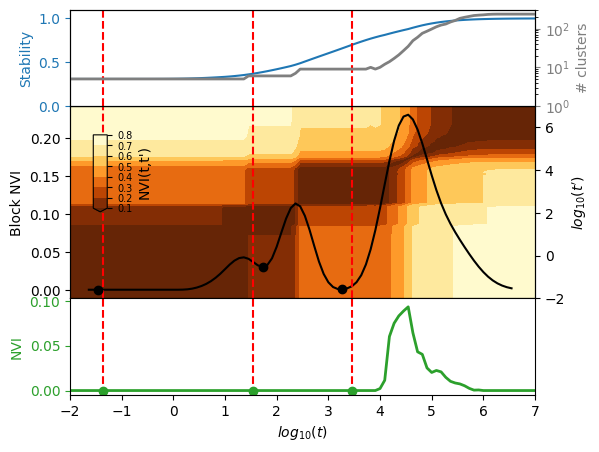

In [28]:
# identify optimal scales
kernel_size = 10 #int(0.36 * n_scale)
window_size = 10 #int(0.05 * n_scale)
basin_radius = 2 #int(0.1 * kernel_size)

all_results_f = pgs.identify_optimal_scales(
    all_results_f,
    kernel_size=kernel_size,
    window_size=window_size,
    basin_radius=basin_radius,
    store_basins=True,
)

# save results
pgs.save_results(all_results_f, "Results/results_f.pkl")

# plot results
pgs.plot_scan_plt(all_results_f, log_scale_n_clusters=True, figure_name="Figures/scale_selection_f.svg")

In [21]:
# extract robust partitions
robust_partitions_f = np.array(all_results_f["community_id"])[all_results_f["selected_partitions"]]
# save robust partitions
np.save(f"Results/robust_partitions_f.npy", robust_partitions_f)

# Sankey diagram

In [13]:
from mcf import Sankey

### Robust partitions

In [22]:
# initialise Sankey
sankey = Sankey(partitions=robust_partitions_f)
fig = sankey.plot_sankey(pad=15,thickness=2)
fig.write_image(f"Figures/robust_sankey_f.svg")

OmicsSankey - Stage 1


100%|██████████| 100/100 [00:00<00:00, 2617.74it/s]


OmicsSankey - Stage 2


100%|██████████| 100/100 [00:00<00:00, 1639.83it/s]


### Full sequence

In [10]:
# initialise Sankey
sankey = Sankey(partitions=all_results_f["community_id"])

# optimise Sankey
sankey.compute_omics_sankey(stage1_iter=200,stage2_iter=2,file_path=f"Results/sankey_f.pkl") 

OmicsSankey - Stage 1


  0%|          | 0/200 [00:00<?, ?it/s]/Users/work/miniconda3/envs/mcf/lib/python3.11/site-packages/omics_sankey/helper.py:149: RuntimeWarning:

divide by zero encountered in matmul

/Users/work/miniconda3/envs/mcf/lib/python3.11/site-packages/omics_sankey/helper.py:149: RuntimeWarning:

overflow encountered in matmul

100%|██████████| 200/200 [01:09<00:00,  2.88it/s]


OmicsSankey - Stage 2


100%|██████████| 2/2 [01:43<00:00, 51.84s/it]


In [27]:
# plot Sankey
sankey = Sankey()
sankey.load_sankey_data(f"Results/sankey_f.pkl")
fig = sankey.plot_sankey(pad=0.5,thickness=2)
fig.write_image(f"Figures/sankey_f.svg")

# MCbiF (not relevant for this project)

In [24]:
from mcf import MCbiF

Construct one-parameter filtration ...


100%|██████████| 100/100 [00:00<00:00, 293.08it/s]


Construct two-parameter filtration ...


100%|██████████| 17427/17427 [00:05<00:00, 3286.37it/s]


Compute 0-dim MPH ...
Compute 1-dim MPH ...

Average persistent hierarchy: 0.406


<Axes: xlabel='$t$', ylabel='$s$'>

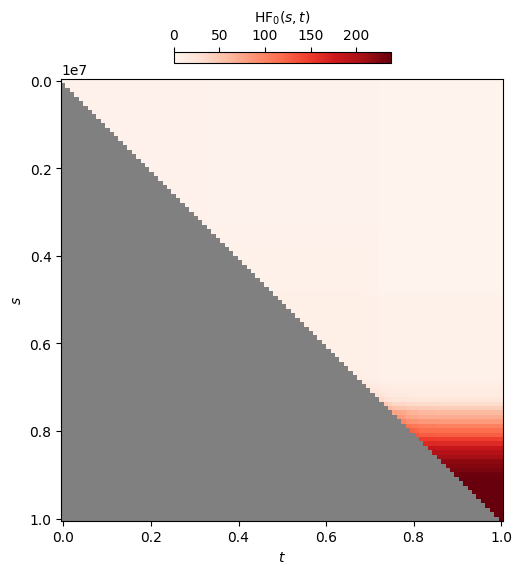

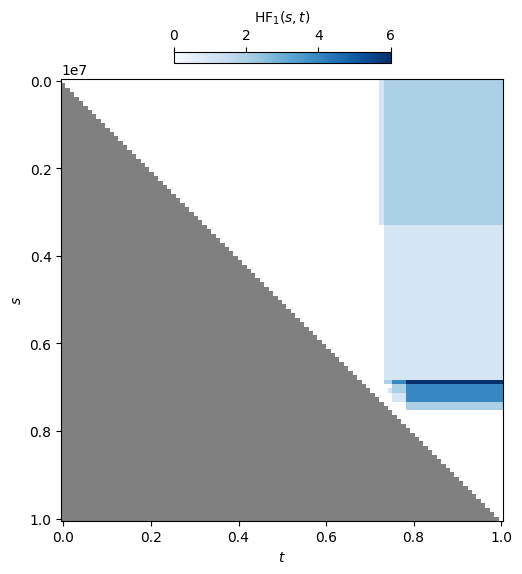

In [25]:
# compute MCbiF
mcbif = MCbiF(method="nerve")
mcbif.load_data(all_results_f["community_id"],all_results_f["scales"])
mcbif_results = mcbif.compute_all_measures(file_path=None, landscape_resolution=-1)
print("\nAverage persistent hierarchy:", round(mcbif.h_bar_,3))

# make plots
mcbif.plot_hilbert_function(0, path="figures/mcbif_cartoon_large_hf0.svg")
mcbif.plot_hilbert_function(1, path="figures/mcbif_cartoon_large_hf1.svg")